# Problema de Negócio:

A dengue é uma doença viral transmitida principalmente pelo mosquito Aedes aegypti e representa um desafio significativo para a saúde pública devido à sua rápida disseminação e impacto na população. Segundo registros históricos, a dengue afeta o Brasil fortemente desde o início do século XX, embora há registros que os primeiros casos tenham sido ainda no período colonial. 

Por isso, é nosso trabalho auxiliar as autoridades de saúde a tomar medidas preventivas e de controle de forma mais eficaz, direcionando melhor os recursos e intervenções necessárias.  

# Objetivo:
Criar um modelo de regressão que informe a previsão da quantidade de casos de dengue para os próximos 1500 dias.

# Estratégia
-  O modelo será construído em Python.
-  Metodologia CRISP.
- A qualidade do modelo será baseada na métrica RMSE.
-  O resultado será apresentado em arquivo CSV contando a previsão.


 # 0.0 Imports

In [82]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import xgboost  as xgb
import inflection
import datetime
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn  import preprocessing   as pp
from sklearn  import ensemble        as en
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics  import  mean_absolute_error, mean_squared_error
from catboost         import CatBoostRegressor
from lightgbm         import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

# 1.0 Functions

In [2]:
def cross_validation(df7,kfold,model_name, model,verbose=False):
    mae_list = []
    rmse_list = []

    for k in reversed(range(1,kfold + 1)):
        if verbose:
            print('\nKFold Number:{}'.format(k))
        #start and end date for validation
        validation_start_date = df7['date'].max() - datetime.timedelta(days=k*1500)
        validation_end_date = df7['date'].max() - datetime.timedelta(days=k*0)

        #filtering dataset
        training = df7[df7['date'] < validation_start_date]
        validation = df7[(df7['date'] >= validation_start_date) & (df7['date'] <= validation_end_date)]

        #training and validation dataset
        
        #training
        xtraining = training.drop(['casos_de_dengue','date'], axis=1)
        ytraining = training['casos_de_dengue']

        #validation
        xvalidation = validation.drop(['casos_de_dengue','date'], axis=1)
        yvalidation = validation['casos_de_dengue']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'RMSE': rmse}, index=[0])
    
def definir_estacao(mes):
    if mes in range(1, 4):
        return 'verao'
    elif mes in range(4, 7):
        return 'outono'
    elif mes in range(7, 10):
        return 'inverno'
    else:
        return 'primavera'
    
def scale_standard(df, columns,ss):
    df[columns] = ss.fit_transform(df[columns].values)
    return df

def rescaling_rs_train(df, columns_robust,rs):
    for column in columns_robust:
        df[column] = rs.fit_transform(df[[column]].values)
    return df
        
def rescalin_mms_train(df, columns_minmax,mms):        
    for column in columns_minmax:
        df[column] = mms.fit_transform(df[[column]].values)
    return df

def encoding_onehot(df, columns):
    df = pd.get_dummies(df, prefix=columns, columns=columns, dtype=int)
    return df

def encoding_target(df, column):
    encoding = df.groupby(column).size() / len(df)
    df[column] = df[column].map(encoding)
    return df

def scale_standard_test(df, columns, ss):
    df[columns] = ss.transform(df[columns].values)
    return df

def rescaling_rs_test(df, columns_robust, rs_dict):
    for column in columns_robust:
        df[column] = rs.transform(df[[column]].values)
    return df

def rescaling_mms_test(df, columns_minmax, mms_dict):
    for column in columns_minmax:
        df[column] = mms.transform(df[[column]].values)
    return df

def data_types(df):
    # Colunas float
    colunas_float = ['presença_de_criadouros', 'água_parada_em_terrenos_baldios', 'precipitação',
                     'umidade', 'temperatura', 'falta_de_coleta_de_lixo', 'áreas_com_acúmulo_de_entulhos',
                     'falta_de_controle_de_pragas', 'taxa_de_tratamento_de_esgoto', 'condições_de_moradia_precárias',
                     'falta_de_acesso_a_serviços_de_saúde', 'migração_de_pessoas_de_áreas_endêmicas',
                     'transporte_de_mercadorias_em_áreas_urbanas', 'outros']
    
    # Convertendo valores para float
    df[colunas_float] = df[colunas_float].replace(',', '.', regex=True)
    df[colunas_float] = df[colunas_float].astype(float)
    
    # Colunas int
    colunas_int = ['presença_de_piscinas_sem_manutenção', 'presença_de_recipientes_sem_tampas', 'presença_do_mosquito']
    
    # Convertendo valores para int64
    df[colunas_int] = df[colunas_int].astype('int64')
    
    return df

def feature(x):
    # year
    x['year'] = x['date'].dt.year

    # month
    x['month'] = x['date'].dt.month

    # day
    x['day'] = x['date'].dt.day

    # week of year
    x['week_of_year'] = x['date'].dt.isocalendar().week

    # estacao
    x['estacao_do_ano'] = x['date'].dt.month.apply(lambda x: definir_estacao(x))

    return x

def encoding_cycles(df, date_columns):
    # week of year
     for column in date_columns:
        if 'week_of_year' in column:
            df[f'{column}_sin'] = df[column].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
            df[f'{column}_cos'] = df[column].apply(lambda x: np.cos(x * (2 * np.pi / 52)))
        elif 'month' in column:
            df[f'{column}_sin'] = df[column].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
            df[f'{column}_cos'] = df[column].apply(lambda x: np.cos(x * (2 * np.pi / 12)))
        elif 'day' in column:
            df[f'{column}_sin'] = df[column].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
            df[f'{column}_cos'] = df[column].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

     return df

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def baseline_function(df1):
    df1_selected = df1.loc[(df1['date'] >= '2014-11-23') & (df1['date'] <= '2018-12-31')].head(1500)

    df2_selected = df1.loc[(df1['date'] >= '2009-11-23') & (df1['date'] <= '2013-12-31')].head(1500)

    df3_selected = df1.loc[(df1['date'] >= '2004-11-23') & (df1['date'] <= '2008-12-31')].head(1500)

    df4_selected = df1.loc[(df1['date'] >= '1999-11-23') & (df1['date'] <= '2003-12-31')].head(1500)

    df5_selected = df1.loc[(df1['date'] >= '1994-11-23') & (df1['date'] <= '1998-12-31')].head(1500)

    y_val1 = df1_selected['casos_de_dengue']
    y_val2 = df2_selected['casos_de_dengue']
    y_val3 = df3_selected['casos_de_dengue']
    y_val4 = df4_selected['casos_de_dengue']
    y_val5 = df5_selected['casos_de_dengue']

    aux10 = X_train.copy()
    aux10['date'] = pd.to_datetime(aux10['date'])
    aux10['date_ok'] = aux10['date'].dt.strftime('%m-%d')

    aux20 = aux10.groupby('date_ok')['casos_de_dengue'].mean().reset_index()

    aux5 = pd.merge(df_base,aux20,how='inner',on='date_ok')
    aux5 = aux5['casos_de_dengue']

    baseline_predictions = aux5.copy()

    mae1 = mean_absolute_error(y_val1, aux5)
    rmse1 = mean_squared_error(y_val1, aux5, squared=False)

    mae2 = mean_absolute_error(y_val2, aux5)
    rmse2 = mean_squared_error(y_val2, aux5, squared=False)

    mae3 = mean_absolute_error(y_val3, aux5)
    rmse3 = mean_squared_error(y_val3, aux5, squared=False)

    mae4 = mean_absolute_error(y_val4, aux5)
    rmse4 = mean_squared_error(y_val4, aux5, squared=False)

    mae5 = mean_absolute_error(y_val5, aux5)
    rmse5 = mean_squared_error(y_val5, aux5, squared=False)

    mae_list = [mae1,mae2,mae3,mae4,mae5]
    rmse_list = [rmse1,rmse2,rmse3,rmse4,rmse5]

    baseline = pd.DataFrame({'Model Name': 'Baseline Model',
                            'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                            'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str) },index=[0])
    return baseline

# 2.0 Loading Dataset

- Acesso ao Banco de Dados 
- 6 tabelas encontradas e analisadas para fazer a união.
- As tabelas foram unidas pela coluna de Data


In [3]:
df_raw1 = pd.read_csv('datasets/agua_parada.csv')
df_raw2 = pd.read_csv('datasets/casos_dengue.csv')
df_raw3 = pd.read_csv('datasets/condicoes_climaticas.csv')
df_raw4 = pd.read_csv('datasets/conscientizacao.csv')
df_raw5 = pd.read_csv('datasets/falta_higiene.csv')
df_raw6 = pd.read_csv('datasets/fato.csv')

# 3.0 Dataset Merge

In [5]:
df0 = pd.merge(df_raw1, df_raw2, on='Date', how='left')
df0 = pd.merge(df0, df_raw3, on='Date', how='left')
df0 = pd.merge(df0, df_raw5, on='Date', how='left')
df0 = pd.merge(df0, df_raw6, on='Date', how='left')

In [84]:
df0.head()

,Date,Presença de Criadouros,Água Parada em Terrenos Baldios,Presença de Piscinas sem Manutenção,Presença de Recipientes sem Tampas,Casos de dengue,Precipitação,Umidade,Temperatura,Falta de Coleta de Lixo,Áreas com Acúmulo de Entulhos,Falta de Controle de Pragas,Taxa de Tratamento de Esgoto,conscientização da população,condições de moradia precárias,falta de acesso a serviços de saúde,migração de pessoas de áreas endêmicas,transporte de mercadorias em áreas urbanas,outros,presença do mosquito
0,1987-01-01,"0,7602152408153650","0,6906838391224580",3057,5501,270499.0,"168,814638","88,1173392608","37,1138254595","0,2465739853795010","0,3448818944689220","0,3733123535682210","0,4300010257992930",2,"0,555259263140639","0,2815108989463590","0,6429925918512230","0,589273493114406","0,0909405702835652",874324
1,1987-01-02,"0,5137786111649520","0,2073712658734020",1696,63609,279224.0,"148,661492","61,2325822580","29,5960029367","0,5863538207685060","0,2986459857247900","0,3732969002670650","0,4300010257992930",2,"0,481989978544179","0,2563120444327210","0,4652202870391560","0,105567816820189","0,4416194993963590",869290
2,1987-01-03,"0,2984419065829870","0,6441713783593510",4996,86840,221681.0,"267,744475",NaN,"26,8440992738","0,1055016803612250","0,1255063475300300","0,3242769262915530","0,4300010257992930",4,"0,661297434399373","0,0547120630133933","0,1264073250507620","0,525688440214732","0,2740564707309670",880145
3,1987-01-04,"0,2053520341773380","0,2431789697272530",4502,89673,76197.0,"162,011169",indisponivel,"29,8703422900","0,5524632899672840","0,3371301817700110","0,4283064809884400","0,4300010257992930",2,"0,327870708301440","0,3175125288904890","0,1968992222918770","0,564144893363298","0,1608833958435060",295600
4,1987-01-05,"0,6968290036485810","0,4120399738531120",4121,55219,94530.0,"278,151803","77,4348162584","29,4186974855","0,1140318003231250","0,4261978367167250","0,3322062734186780","0,4300010257992930",2,"0,246563217613570","0,2475953587478760","0,7411695099122610","0,218586199073160","0,1974662118278430",681702


# 4.0 Rename Columns

In [6]:
df1 = df0.copy() 

In [7]:
df1 = df0.copy()

cols_old = ['Date', 
            'Presença de Criadouros', 
            'Água Parada em Terrenos Baldios',
            'Presença de Piscinas sem Manutenção',
            'Presença de Recipientes sem Tampas', 
            'Casos de dengue', 
            'Precipitação',
            'Umidade', 
            'Temperatura', 
            'Falta de Coleta de Lixo', 
            'Áreas com Acúmulo de Entulhos', 
            'Falta de Controle de Pragas',
            'Taxa de Tratamento de Esgoto', 
            'conscientização da população',
            'condições de moradia precárias', 
            'falta de acesso a serviços de saúde',
            'migração de pessoas de áreas endêmicas',
            'transporte de mercadorias em áreas urbanas', 
            'outros',
            'presença do mosquito']

snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase, cols_old))

# adjusting columns names and replacing spaces per '_'
df1.columns = cols_new
df1.columns = df1.columns.str.replace(' ', '_')

# 5.0 Split dataset in train and test

In [8]:
# training dataset
X_train = df1.loc[df1['date'] < '2019-11-23',:]
y_train = X_train['casos_de_dengue']

#test dataset
X_test = df1.loc[df1['date'] >= '2019-11-23',:]
y_test = X_test['casos_de_dengue']

# 6.0 Data Description

In [9]:
df2 = X_train.copy()

In [97]:
print(f'Dimensões do arquivo de treino: \nLinhas: { X_train.shape[0] }\nColunas: {X_train.shape[1]}')

Dimensões do arquivo de treino: 
Linhas: 12014
Colunas: 20


## 6.1 Data Types

In [11]:
df2['date'] = pd.to_datetime(df2['date'])
df2.dtypes

date                                          datetime64[ns]
presença_de_criadouros                                object
água_parada_em_terrenos_baldios                       object
presença_de_piscinas_sem_manutenção                   object
presença_de_recipientes_sem_tampas                    object
casos_de_dengue                                      float64
precipitação                                          object
umidade                                               object
temperatura                                           object
falta_de_coleta_de_lixo                               object
áreas_com_acúmulo_de_entulhos                         object
falta_de_controle_de_pragas                           object
taxa_de_tratamento_de_esgoto                          object
conscientização_da_população                           int64
condições_de_moradia_precárias                        object
falta_de_acesso_a_serviços_de_saúde                   object
migração_de_pessoas_de_á

## 6.2 checking "NaN" and "Indisponivel "

In [12]:
df2.isna().sum()

date                                           0
presença_de_criadouros                        74
água_parada_em_terrenos_baldios               68
presença_de_piscinas_sem_manutenção           59
presença_de_recipientes_sem_tampas            67
casos_de_dengue                                0
precipitação                                  53
umidade                                       65
temperatura                                   54
falta_de_coleta_de_lixo                       59
áreas_com_acúmulo_de_entulhos                 56
falta_de_controle_de_pragas                   69
taxa_de_tratamento_de_esgoto                  65
conscientização_da_população                   0
condições_de_moradia_precárias                62
falta_de_acesso_a_serviços_de_saúde           91
migração_de_pessoas_de_áreas_endêmicas        69
transporte_de_mercadorias_em_áreas_urbanas    63
outros                                        56
presença_do_mosquito                          53
dtype: int64

In [13]:
df2.isin(['indisponivel']).sum()

date                                           0
presença_de_criadouros                        45
água_parada_em_terrenos_baldios               66
presença_de_piscinas_sem_manutenção           53
presença_de_recipientes_sem_tampas            64
casos_de_dengue                                0
precipitação                                  69
umidade                                       66
temperatura                                   73
falta_de_coleta_de_lixo                       63
áreas_com_acúmulo_de_entulhos                 52
falta_de_controle_de_pragas                   54
taxa_de_tratamento_de_esgoto                  72
conscientização_da_população                   0
condições_de_moradia_precárias                60
falta_de_acesso_a_serviços_de_saúde           65
migração_de_pessoas_de_áreas_endêmicas        63
transporte_de_mercadorias_em_áreas_urbanas    69
outros                                        63
presença_do_mosquito                          59
dtype: int64

## 6.3 Checking if it is feasible to delete "NaN" and "indisponivel"

In [14]:
# counting total rows
df2_total_row = len(df2)

# counting total rows without NaN
df2_row_sem_na = len(df2.dropna())

# checking difference between them
linhas_excluidas = df2_total_row - df2_row_sem_na

# replacing Indisponivel with NaN
df_sem_indisponivel = df2.replace('indisponivel', np.nan)

# Excluir todas as linhas que contenham NaN
df_sem_na_indisponivel = df_sem_indisponivel.dropna()

# Calcular quantas linhas seriam excluídas
linhas_excluidas = len(df2) - len(df_sem_na_indisponivel)


print(f"Total de linhas excluídas se deletar todos os NaN é {linhas_excluidas}.")
print(f'Total de linhas excluídas se deletar todas as linhas que estão "indisponivel" são {linhas_excluidas}.')

Total de linhas excluídas se deletar todos os NaN é 1977.
Total de linhas excluídas se deletar todas as linhas que estão "indisponivel" são 1977.


## 6.4 Fillout NA and Indisponivel

In [15]:
df2 = df2.replace('indisponivel', np.nan)

df2 = df2.fillna(method='ffill', limit=7) 

C:\Users\rseme\AppData\Local\Temp\ipykernel_28160\3004272734.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2 = df2.fillna(method='ffill', limit=7)


In [16]:
df2.isna().sum()

date                                          0
presença_de_criadouros                        0
água_parada_em_terrenos_baldios               0
presença_de_piscinas_sem_manutenção           0
presença_de_recipientes_sem_tampas            0
casos_de_dengue                               0
precipitação                                  0
umidade                                       0
temperatura                                   0
falta_de_coleta_de_lixo                       0
áreas_com_acúmulo_de_entulhos                 0
falta_de_controle_de_pragas                   0
taxa_de_tratamento_de_esgoto                  0
conscientização_da_população                  0
condições_de_moradia_precárias                0
falta_de_acesso_a_serviços_de_saúde           0
migração_de_pessoas_de_áreas_endêmicas        0
transporte_de_mercadorias_em_áreas_urbanas    0
outros                                        0
presença_do_mosquito                          0
dtype: int64

In [17]:
df2.isin(['indisponivel']).sum()

date                                          0
presença_de_criadouros                        0
água_parada_em_terrenos_baldios               0
presença_de_piscinas_sem_manutenção           0
presença_de_recipientes_sem_tampas            0
casos_de_dengue                               0
precipitação                                  0
umidade                                       0
temperatura                                   0
falta_de_coleta_de_lixo                       0
áreas_com_acúmulo_de_entulhos                 0
falta_de_controle_de_pragas                   0
taxa_de_tratamento_de_esgoto                  0
conscientização_da_população                  0
condições_de_moradia_precárias                0
falta_de_acesso_a_serviços_de_saúde           0
migração_de_pessoas_de_áreas_endêmicas        0
transporte_de_mercadorias_em_áreas_urbanas    0
outros                                        0
presença_do_mosquito                          0
dtype: int64

## 6.7 Change Column Types

In [18]:
df2 = data_types(df2)
df2['casos_de_dengue'] = df2['casos_de_dengue'].astype('int64')

In [19]:
df2.dtypes

date                                          datetime64[ns]
presença_de_criadouros                               float64
água_parada_em_terrenos_baldios                      float64
presença_de_piscinas_sem_manutenção                    int64
presença_de_recipientes_sem_tampas                     int64
casos_de_dengue                                        int64
precipitação                                         float64
umidade                                              float64
temperatura                                          float64
falta_de_coleta_de_lixo                              float64
áreas_com_acúmulo_de_entulhos                        float64
falta_de_controle_de_pragas                          float64
taxa_de_tratamento_de_esgoto                         float64
conscientização_da_população                           int64
condições_de_moradia_precárias                       float64
falta_de_acesso_a_serviços_de_saúde                  float64
migração_de_pessoas_de_á

# 7.0 Descriptive Statiscal

In [20]:
num_attributes = df2.select_dtypes(include=['int64','float64'])
cat_attributes = df2.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,presença_de_criadouros,0.100303,0.799997,0.699694,0.447807,0.447510,0.201309,0.006121,-1.197204
1,água_parada_em_terrenos_baldios,0.100023,0.699950,0.599927,0.398769,0.397005,0.172895,0.014998,-1.197575
2,presença_de_piscinas_sem_manutenção,200.000000,4999.000000,4799.000000,2586.223489,2585.000000,1383.142070,0.007462,-1.198503
3,presença_de_recipientes_sem_tampas,1007.000000,99969.000000,98962.000000,50379.707841,50446.000000,28732.544576,0.002036,-1.206737
4,casos_de_dengue,0.000000,756493.000000,756493.000000,43333.574496,10595.000000,77401.147960,2.679727,8.393474
5,precipitação,0.009322,299.966579,299.957257,84.706760,54.061266,78.751686,1.230978,0.397353
6,umidade,40.005175,94.995987,54.990812,65.967392,65.316974,12.942665,0.197591,-0.532773
7,temperatura,14.003989,37.991244,23.987255,25.231033,24.929024,5.316374,0.243354,-0.257188
8,falta_de_coleta_de_lixo,0.050019,0.599960,0.549941,0.323197,0.320372,0.158859,0.016343,-1.198883
9,áreas_com_acúmulo_de_entulhos,0.100247,0.799981,0.699734,0.451350,0.450117,0.201703,-0.007550,-1.193081


# 8.0 Feature Engineering

In [22]:
df3 = df2.copy()

## 8.1 Criação das Hipóteses

**1.** Dias mais chuvosos devem ter mais casos

**2.** Meses do verão devem ter mais casos.

**3.** Temperaturas mais altas devem ter mais casos.

**4.** Quanto maior a conscientização da populacao há menos casos.

**5.** Menor presença de mosquitos deve resultar em menos chances de casos.

**6.** Dias menos úmidos devem resultar em menos casos.

**7.** Os casos de dengue aumentam ao longo do tempo



## 8.2 Featuring Engineering

- year
- month
- day
- Week of Year
- estação

In [23]:
df3 = feature(df3)

# 9.0 Data Filtering

In [87]:
df4 = df3.copy()

Filtro Realizado para retirada dos outliers (limite de 5% do dataset)

In [25]:
df4 = df4[(df4['casos_de_dengue'] < 220000)]

# 10.0 Exploratory Data Analysis

In [26]:
df5 = df4.copy()

## 10.1 Análise Univariada

### 10.1.1 Variável Resposta

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


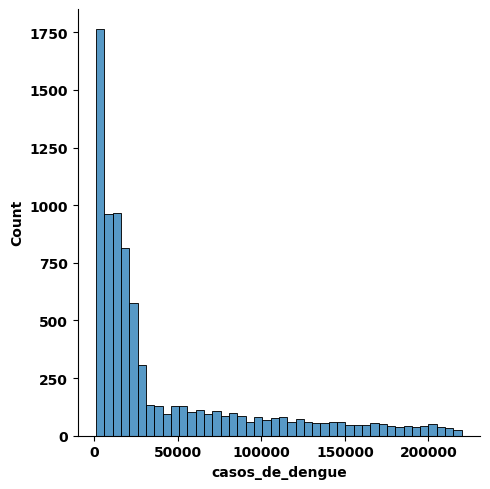

In [94]:
df_aux = df5[(df5['casos_de_dengue'] > 1000)]
sns.displot(df_aux['casos_de_dengue'])

### 10.1.2 Análise Univariada

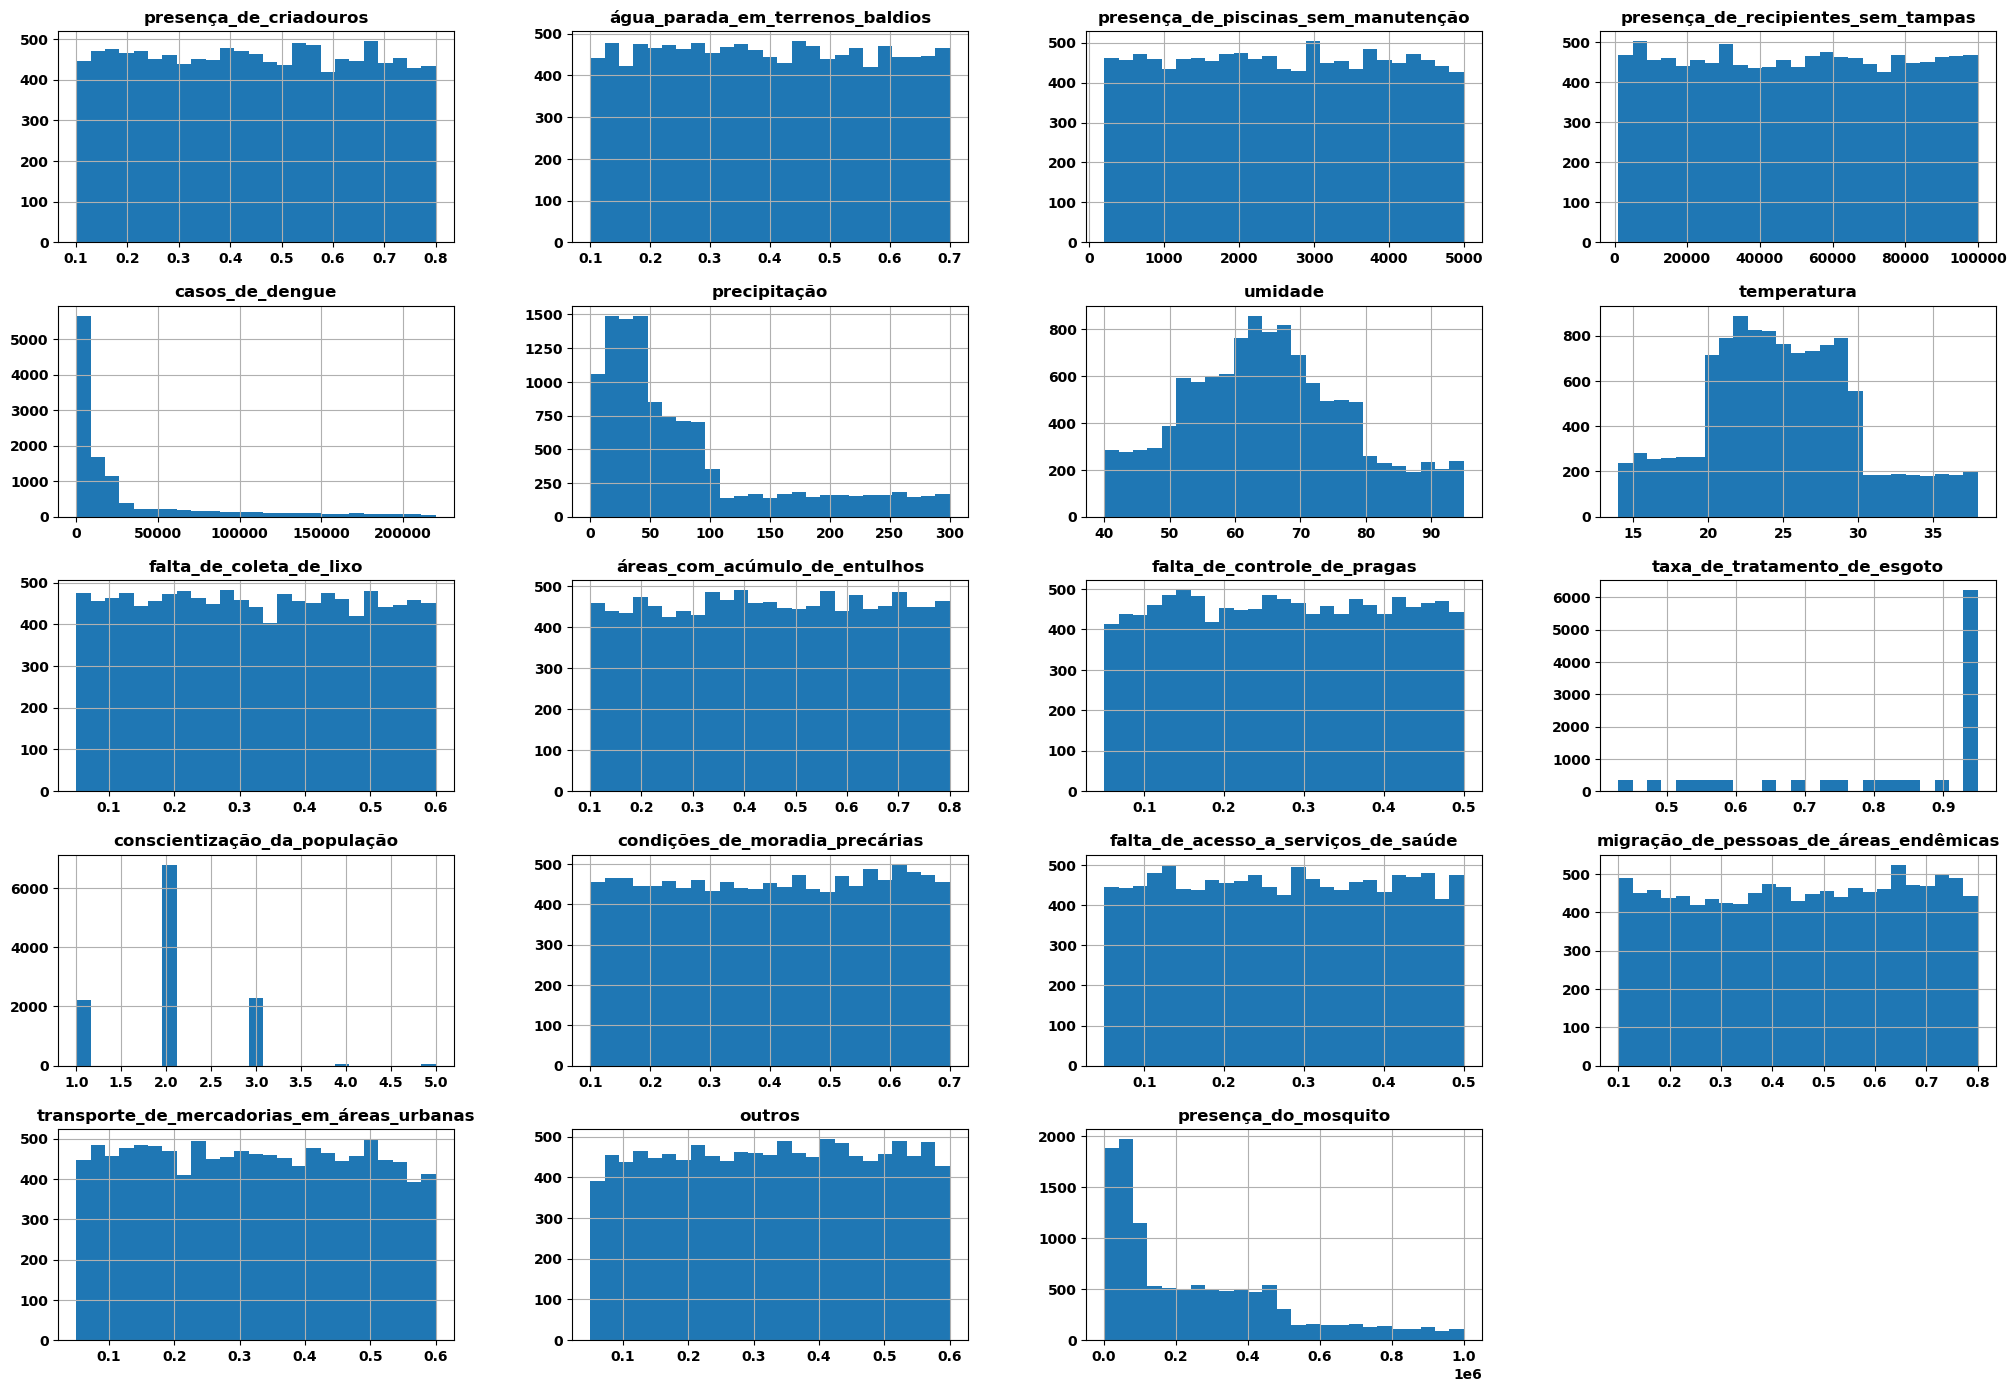

In [100]:
num_attributes = df5.select_dtypes(include=['int64','float64'])
num_attributes.hist(bins=25, figsize=(25, 17));

## 10.2 Análise Bivariada

**H1.** Dias mais chuvosos devem ter mais casos.

**FALSA**. Nas precipitações mais altas não há predominância de dias com alto registro de casos.

- Em mais da metade dos dias mais chuvosos (acima de 200mm), menos de 100 mil casos foram registrados


<Axes: xlabel='precipitação', ylabel='casos_de_dengue'>

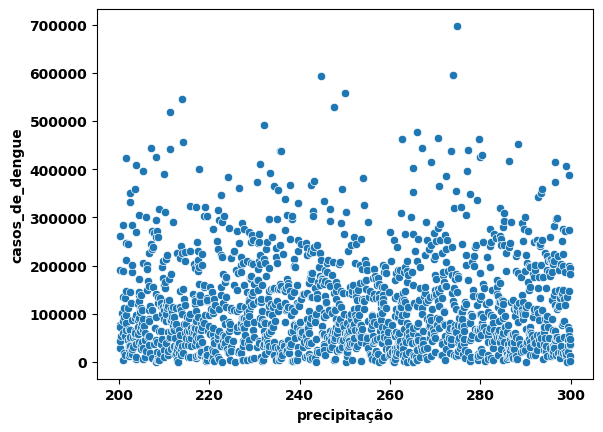

In [29]:
aux = df2.loc[df2['precipitação'] > 200, ['precipitação', 'casos_de_dengue']].groupby( 'precipitação' ).mean().reset_index()
#sns.barplot( x='precipitação', y='casos_de_dengue', data=aux1)
sns.scatterplot(x='precipitação', y='casos_de_dengue', data=aux)

In [30]:
aux[aux['casos_de_dengue'] < 100000].count()/aux.shape[0]

precipitação       0.526048
casos_de_dengue    0.526048
dtype: float64

**H2.** Meses do verão devem ter mais casos.

**VERDADEIRA**. Meses do verão tem mais casos

- Aproximadamente 90% dos casos foram registrados nos meses de Janeiro, Fevereiro, Março e Dezembro:

Nesses meses, as campanhas de combate ao mosquito devem ser intensificadas e os cuidados com locais que se acumulam águas devem ser ampliados.

In [31]:
aux1 = X_train.copy()
aux1['date'] = pd.to_datetime(aux1['date'])
aux1['date_format'] = aux1['date'].apply(lambda x: x.strftime('%m'))
aux1

meses_verao = ['01', '02', '03', '12']
aux_verao = aux1[aux1['date_format'].isin(meses_verao)]

aux_verao['casos_de_dengue'].sum()/aux1['casos_de_dengue'].sum()

0.8968843933877481

<Axes: xlabel='date_format', ylabel='casos_de_dengue'>

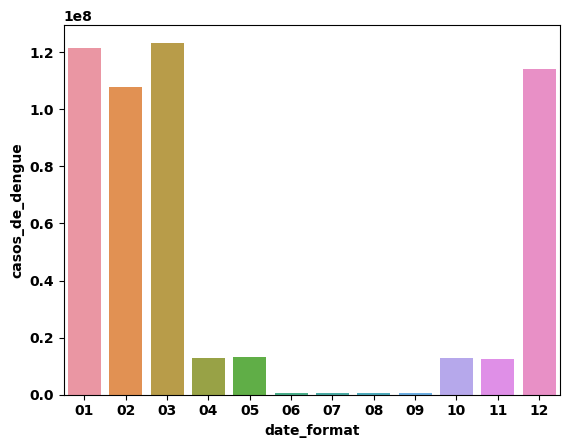

In [32]:
aux1 = X_train.copy()
aux1['date'] = pd.to_datetime(aux1['date'])
aux1['date_format'] = aux1['date'].apply(lambda x: x.strftime('%m'))

aux3 = aux1[['date_format','casos_de_dengue']].groupby('date_format').sum().reset_index()
sns.barplot(x='date_format', y='casos_de_dengue', data=aux3)

**H3.** Temperaturas mais altas devem ter mais casos.

**FALSA**. Nas temperaturas mais altas não há predominância de dias com alto registro de casos.

- Em mais da metade dos dias mais quentes (acima de 35°), menos de 100 mil casos foram registrados



<Axes: xlabel='temperatura', ylabel='casos_de_dengue'>

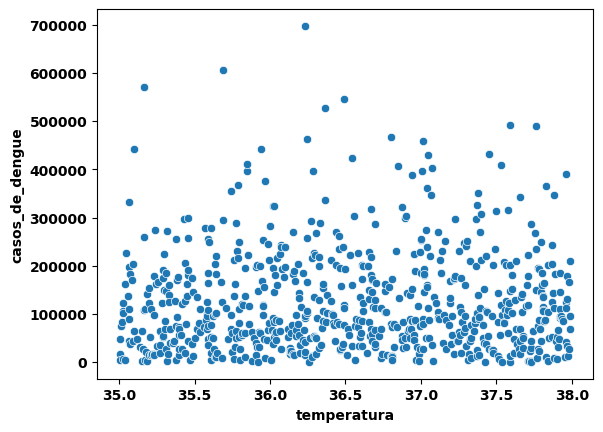

In [105]:
aux35 = df2.loc[df2['temperatura']>35,['temperatura', 'casos_de_dengue']].groupby( 'temperatura' ).mean().reset_index()
#sns.barplot( x='temperatura', y='casos_de_dengue', data=aux3)
sns.scatterplot(x='temperatura', y='casos_de_dengue', data=aux35)
#sns.countplot( x=df5['áreas_com_acúmulo_de_entulhos'] )

In [34]:
aux35[aux35['casos_de_dengue'] < 100000].count()/aux35.shape[0]

temperatura        0.517241
casos_de_dengue    0.517241
dtype: float64

**H4.** Quanto maior a conscientização da população deveria ter menos casos.

**FALSA**. Em qualquer nível de conscientização, a média de casos registrados é muito próxima. 
- As campanhas de conscientização devem ser melhoradas para que possam surtir efeitos
- Mesmo que a população esteja consciente em relação às medidas de combate ao mosquito, pode ser que os desafios na implementação dos cuidados sejam enormes.

<Axes: xlabel='conscientização_da_população', ylabel='casos_de_dengue'>

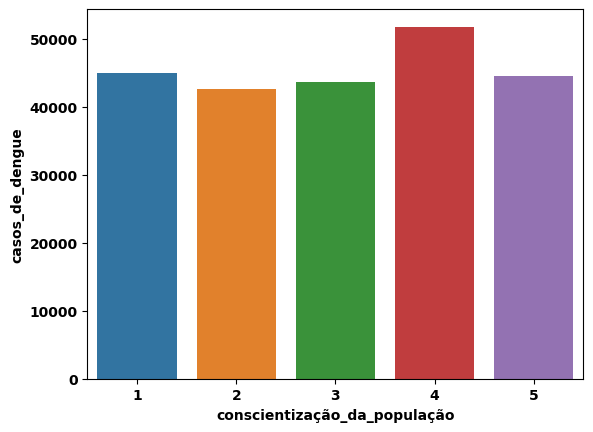

In [35]:
aux2 = df2[['conscientização_da_população', 'casos_de_dengue']].groupby( 'conscientização_da_população' ).mean().reset_index()
sns.barplot( x='conscientização_da_população', y='casos_de_dengue', data=aux2)
#sns.scatterplot(x='conscientização_da_população', y='casos_de_dengue', data=aux2)
#sns.countplot( x=df5['conscientização_da_população'] )

**H5.** Menor presença de mosquitos deve resultar em menos chances de casos.

**VERDADEIRA**. Os dados mostram que quanto menor a presença de mosquitos, menos casos são registrados
  
- Para registros menores que 150 mil mosquitos, apenas uma vez se constatou mais de 70 mil casos de dengue. 

Para a diminuição dos mosquitos transmissores, podem ser tomadas medidas como maior uso de repelentes, inseticidas, telas de proteção, além de tentar eliminar o máximo de criadouros de água, como  plantas, pneus velhos, barris e calhas entupidas.

<Axes: xlabel='presença_do_mosquito', ylabel='casos_de_dengue'>

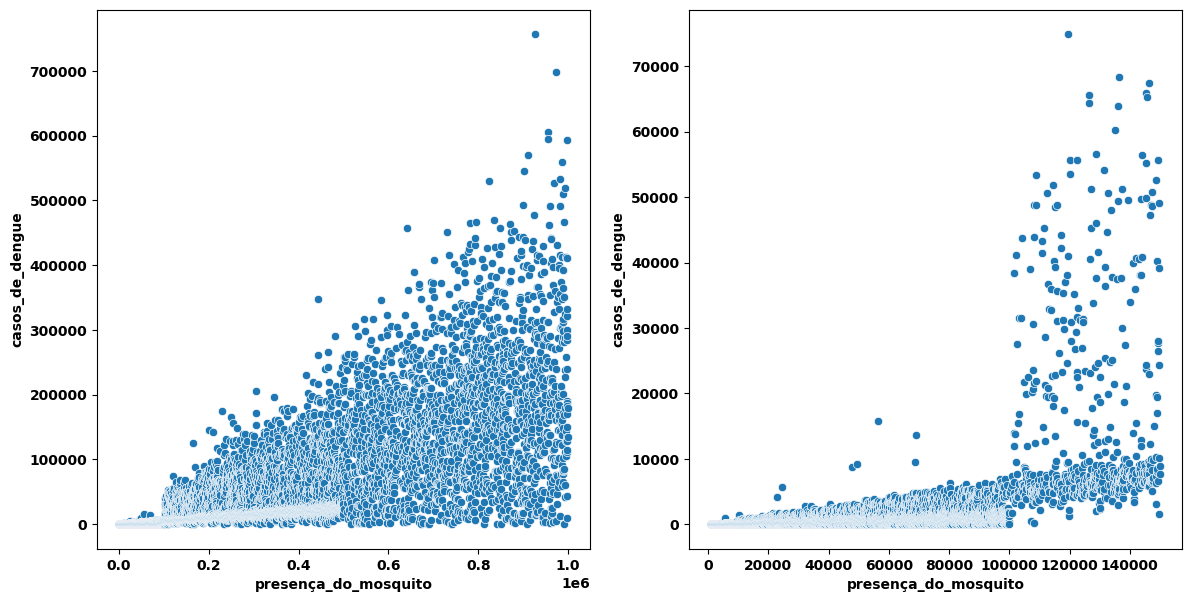

In [95]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
aux8 = df2[['presença_do_mosquito', 'casos_de_dengue']].groupby( 'presença_do_mosquito' ).mean().reset_index()
sns.scatterplot(x='presença_do_mosquito', y='casos_de_dengue', data=aux8)

plt.subplot(1,2,2)
aux81 = df2.loc[df2['presença_do_mosquito'] < 150000,['presença_do_mosquito', 'casos_de_dengue']].groupby( 'presença_do_mosquito' ).mean().reset_index()
sns.scatterplot(x='presença_do_mosquito', y='casos_de_dengue', data=aux81)

**H6.** Dias menos úmidos devem resultar em menos casos.

**VERDADEIRA**. O gráfico mostra poucos registros quando a umidade é baixa.
  
- Menos de 1% dos casos ocorre quando a umidade está abaixo de 50% 
- Mais de 82% dos casos ocorrem quando a umidade está acima de 65%


<Axes: xlabel='umidade', ylabel='casos_de_dengue'>

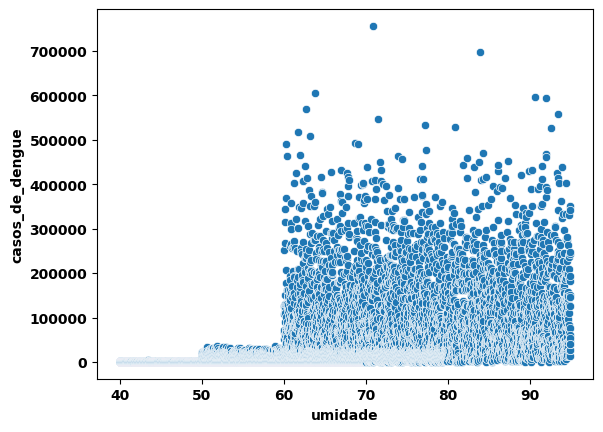

In [38]:
aux87 = df2[['umidade', 'casos_de_dengue']].groupby( 'umidade' ).mean().reset_index()
#sns.barplot( x='presença_do_mosquito', y='casos_de_dengue', data=aux8)
sns.scatterplot(x='umidade', y='casos_de_dengue', data=aux87)
#sns.countplot( x=df5['conscientização_da_população'] )

In [39]:
aux33 = df2.loc[df2['umidade'] < 50,['umidade', 'casos_de_dengue']].groupby( 'umidade' ).sum().reset_index()
aux33['casos_de_dengue'].sum()/X_train['casos_de_dengue'].sum()

0.0013827560033069235

In [40]:
aux433 = df2.loc[df2['umidade'] > 65, ['umidade', 'casos_de_dengue']].groupby( 'umidade' ).sum().reset_index()
aux433['casos_de_dengue'].sum()/df2['casos_de_dengue'].sum()

0.8210442807001525

**H7.** Os casos de dengue aumentam ao longo dos anos.

**FALSA**. Os casos de dengue se movimentaram ao longo dos anos dentro de um intervalo entre 13 e 18 milhões de casos por ano.

- Diante disso, para os próximos 4 anos (aproximadamente 1500 dias), podemos esperar um total entre 52 e 72 milhões de casos.

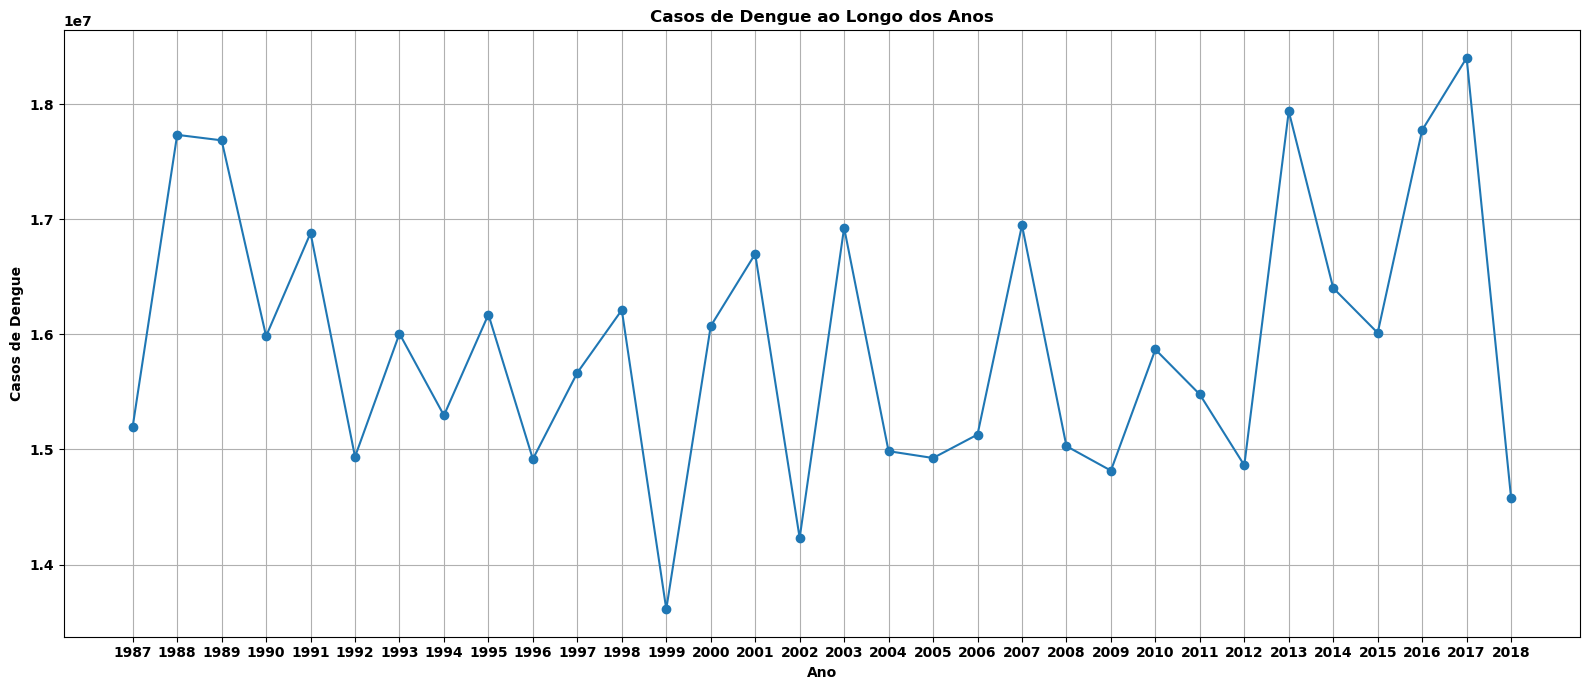

In [41]:
aux200 = df3.loc[df3['year'] < 2019, ['year', 'casos_de_dengue']].groupby('year').sum().reset_index()
years = aux200['year']
cases = aux200['casos_de_dengue']

plt.figure(figsize=(16, 7))
plt.plot(years, cases, marker='o', linestyle='-')
plt.title('Casos de Dengue ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Casos de Dengue')
plt.grid(True)
plt.xticks(years)  
plt.tight_layout()
plt.show()

# Os 4 Insights Acionáveis

### 1. Nos meses do verão há mais registros de casos de dengue. aproximadamente 90% dos casos foram registrados nos meses de Janeiro, Fevereiro, Março e Dezembro:

- Vacinas e prevenção devem ser feitas antes desse período;
- Os recursos de atendimento nos hospitais e leitos devem ser preparados para receber um aumento de pessoas.
- Existirá um aumento nos custos hospitalares e locais de atendimento.
- Nesses meses, as campanhas de combate ao mosquito devem ser intensificadas e os cuidados com locais que se acumulam águas devem ser ampliados.

### 2. Em qualquer nível de conscientização, a média de casos registrados é muito próxima.

- Campanhas não estão atingindo o público correto ou de forma clara;
- As campanhas estão sendo feitas de forma tardia ou apenas nos meses com mais casos, impedindo a criação de uma cultura na atitude das pessoas que realmente impeça criadouros de mosquitos.
- Mesmo que a população esteja consciente em relação às medidas de combate ao mosquito, pode ser que os desafios na implementação dos cuidados sejam maiores.

### 3. Quanto menor a presença de mosquitos, menos casos são registrados.Para registros menores que 150 mil mosquitos, apenas uma vez se constatou mais de 70 mil casos de dengue.

- Impedir a criação do mosquito ainda pode ser considerado uma forma de evitar a doença.
- Locais abandonados devem ter um tratamento diferenciado para que o trabalho de prevenção não seja prejudicado por estes locais.
- Para a diminuição dos mosquitos transmissores, podem ser tomadas medidas como maior uso de repelentes, inseticidas, telas de proteção, tentar eliminar o máximo de criadouros de água, entre outros cuidados.

### 4. Menos de 1% dos casos ocorre quando a umidade está abaixo de 50% e mais de 82% dos casos ocorrem quando a umidade está acima de 65%
- A umidade mais alta facilita criadouro de mosquitos e dificulta a evaporação de água parada.
- Nos dias mais úmidos, o cuidado deve ser intensificado.

## 10.3 Análise Multivariada

## 10.3.1 Numerical Attributes

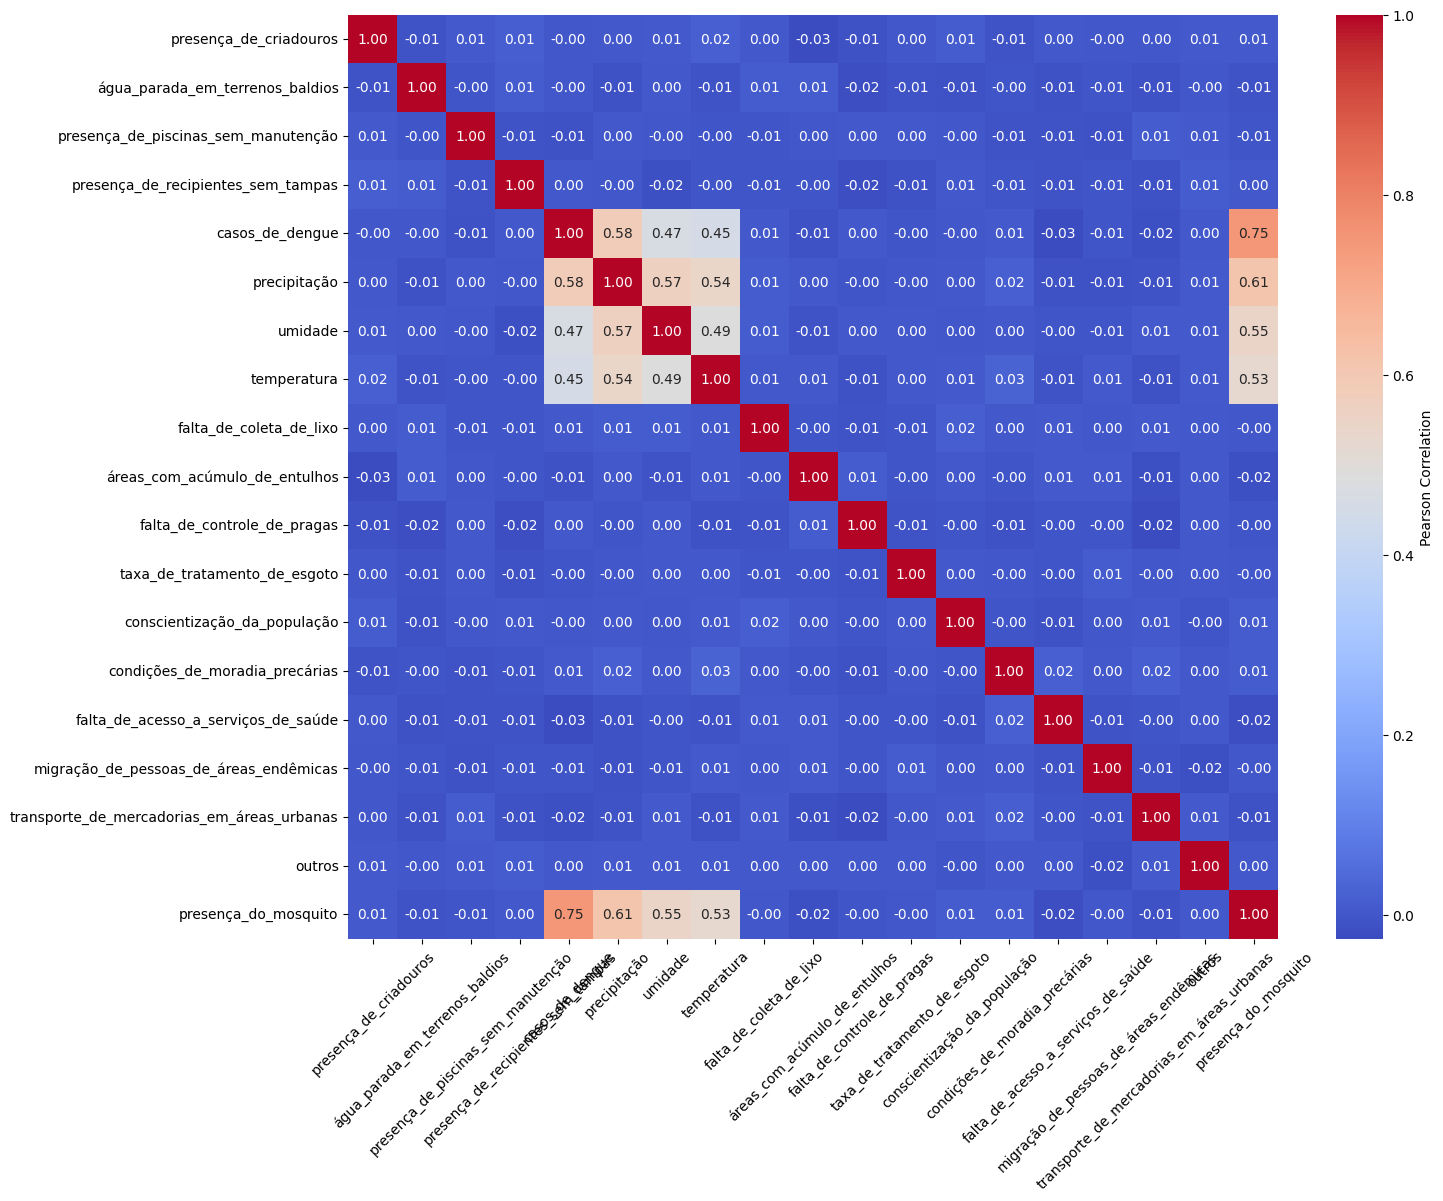

<Figure size 1500x1200 with 0 Axes>

In [93]:
correlacao = num_attributes.corr(method='pearson')
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'}, annot_kws={"size": 10})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.show()

# 11.0 Data Preparation

In [43]:
df6 = df5.copy()

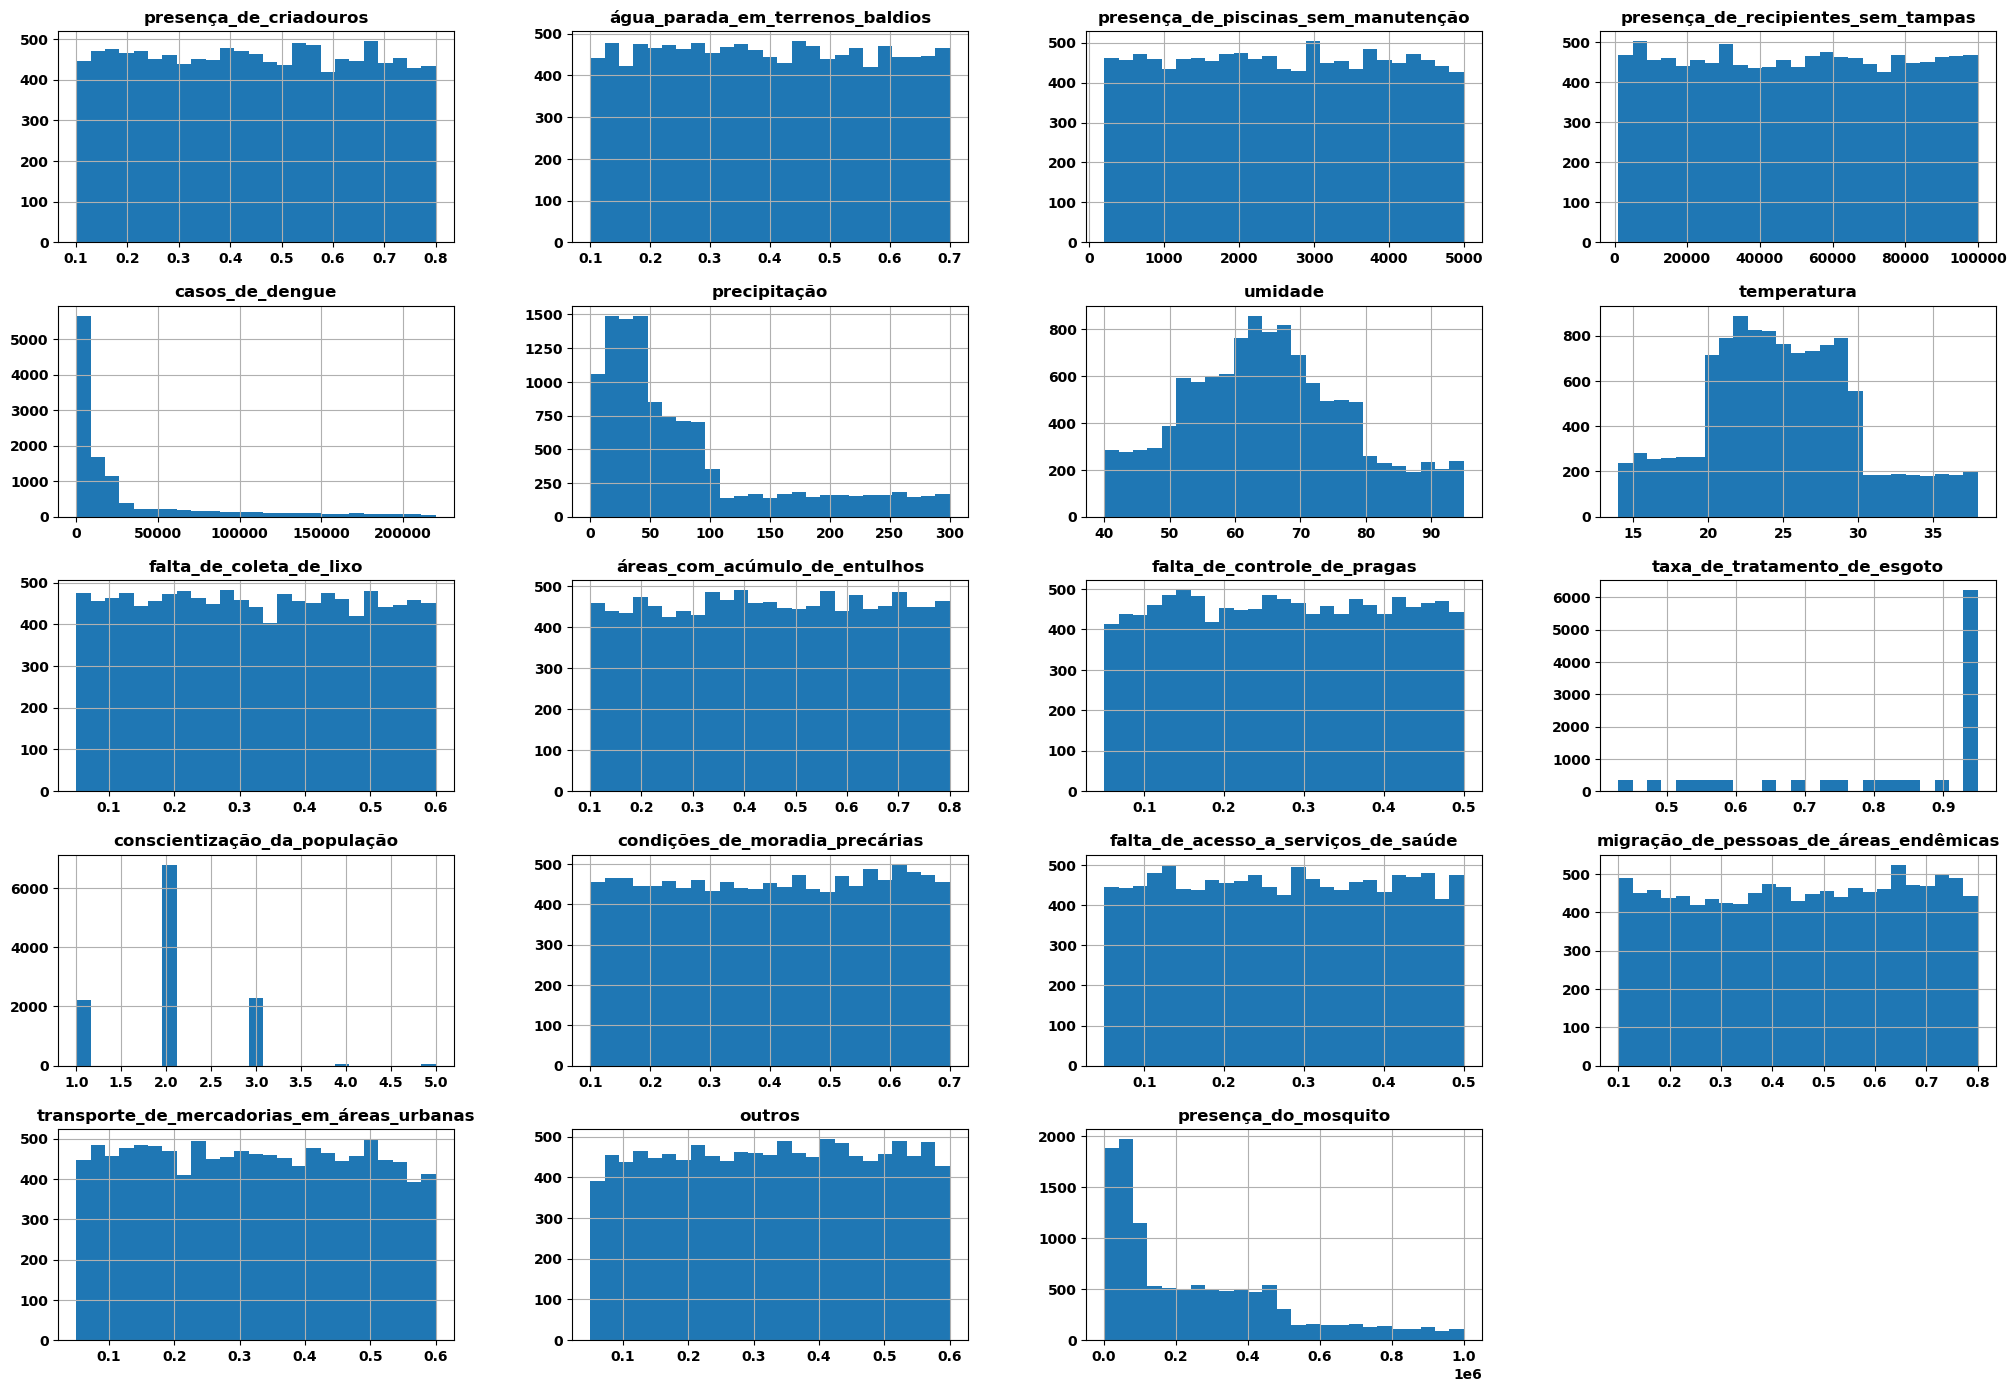

In [101]:
num_attributes = df5.select_dtypes(include=['int64','float64'])
num_attributes.hist(bins=25, figsize=(25, 17));

## 11.1 Normalização

In [44]:
ss = pp.StandardScaler()
df6 = scale_standard(df6,['umidade', 'temperatura'],ss)

## 11.2 Rescaling

In [45]:
rs = RobustScaler()
df6 = rescaling_rs_train(df6, ['taxa_de_tratamento_de_esgoto'],rs)

mms = MinMaxScaler()   
df6 = rescalin_mms_train(df6,[
                'presença_de_criadouros', 'água_parada_em_terrenos_baldios', 'presença_de_piscinas_sem_manutenção',
                'presença_de_recipientes_sem_tampas', 'precipitação', 'falta_de_coleta_de_lixo',
                'áreas_com_acúmulo_de_entulhos', 'falta_de_controle_de_pragas', 'condições_de_moradia_precárias',
                'falta_de_acesso_a_serviços_de_saúde', 'migração_de_pessoas_de_áreas_endêmicas',
                'transporte_de_mercadorias_em_áreas_urbanas', 'outros', 'presença_do_mosquito', 'year'
                ],mms)


## 11.3 Encoding

In [46]:
df6 = encoding_target(df6,'conscientização_da_população')

df6 = encoding_onehot(df6, ['estacao_do_ano'])

### 11.3.1 Nature Transformation

In [47]:
df6 = encoding_cycles(df6, ['week_of_year', 'month', 'day'])

In [48]:
df6 = df6.drop(['week_of_year','day','month'], axis=1)

### 11.3.2 Response Variable Transformation

In [49]:
df6['casos_de_dengue'] = np.log1p(df5['casos_de_dengue'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


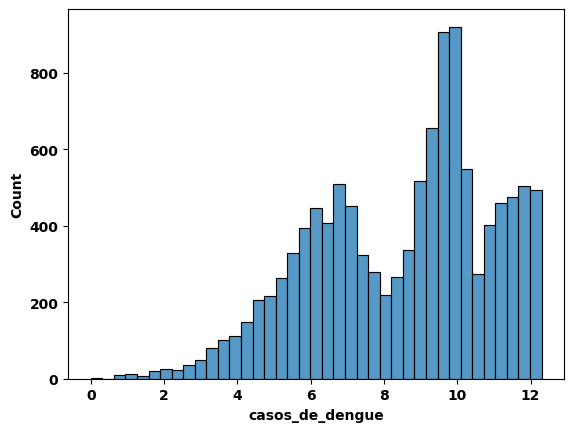

In [50]:
sns.histplot(df6['casos_de_dengue']);

# 12.0 Test Dataset

In [51]:
x_test = X_test.copy()

In [52]:
x_test = x_test.drop('casos_de_dengue', axis=1)
x_test['date'] = pd.to_datetime(x_test['date'])

## 12.1 Fill NA

In [53]:
x_test = x_test.replace('indisponivel', np.nan)

x_test = x_test.fillna(method='ffill', limit=7) 

C:\Users\rseme\AppData\Local\Temp\ipykernel_28160\98592881.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_test = x_test.fillna(method='ffill', limit=7)


## 12.2 Change Types

In [54]:
x_test = data_types(x_test)

## 12.3 Feature Engineering

In [55]:
x_test = feature(x_test)

## 12.4 Data Preparation

In [56]:
x_test = scale_standard_test(x_test, ['umidade', 'temperatura'],ss)

x_test = rescaling_rs_test(x_test,['taxa_de_tratamento_de_esgoto'],rs)

x_test = rescaling_mms_test(x_test,[
                'presença_de_criadouros', 'água_parada_em_terrenos_baldios', 'presença_de_piscinas_sem_manutenção',
                'presença_de_recipientes_sem_tampas', 'precipitação', 'falta_de_coleta_de_lixo',
                'áreas_com_acúmulo_de_entulhos', 'falta_de_controle_de_pragas', 'condições_de_moradia_precárias',
                'falta_de_acesso_a_serviços_de_saúde', 'migração_de_pessoas_de_áreas_endêmicas',
                'transporte_de_mercadorias_em_áreas_urbanas', 'outros', 'presença_do_mosquito', 'year'
                ], mms)

x_test = encoding_onehot(x_test, ['estacao_do_ano'])

x_test = encoding_target(x_test,'conscientização_da_população')

x_test = encoding_cycles(x_test, ['week_of_year', 'month', 'day'])

In [57]:
x_test = x_test.drop(['week_of_year','day','month'], axis=1)
x_test = x_test.drop('date', axis=1)

# 13.0 Train Preparation

In [58]:
df7 = df6.copy()

In [59]:
x_train = df7.drop('casos_de_dengue', axis =1)
y_train = df7['casos_de_dengue']

# 14.0 Feature Selection

## 14.1 Feature Importance

Técnica que permite entender quais variáveis de entrada têm mais influência nos resultados.

In [60]:
# model
forest = ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

# Preparação dos dados
x_train_n = x_train.drop('date', axis=1)
y_train_n = y_train.values

# Dividir os dados em batches
batch_size = 1000
num_batches = len(x_train_n) // batch_size + 1  

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(x_train_n))
    
    x_batch = x_train_n.iloc[start_idx:end_idx]
    y_batch = y_train_n[start_idx:end_idx]
    
    forest.fit(x_batch, y_batch)

Feature ranking:
                                      feature  importance
0                      estacao_do_ano_inverno    0.418895
0                        presença_do_mosquito    0.269738
0                                   month_cos    0.047739
0                            week_of_year_cos    0.041807
0                                   month_sin    0.036895
0                       estacao_do_ano_outono    0.024898
0                                precipitação    0.020910
0                        estacao_do_ano_verao    0.017462
0                            week_of_year_sin    0.012950
0                                     umidade    0.008356
0                                 temperatura    0.008224
0               áreas_com_acúmulo_de_entulhos    0.007764
0      migração_de_pessoas_de_áreas_endêmicas    0.007014
0              condições_de_moradia_precárias    0.006850
0                     falta_de_coleta_de_lixo    0.006171
0                                      outros    0.0061

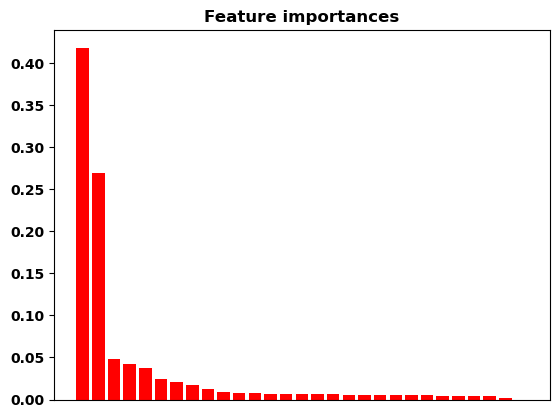

In [61]:
importances = forest.feature_importances_

print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, importances):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 ).sort_values( 'importance', ascending=False )
    
print( df )

plt.figure()
plt.title("Feature importances")
plt.bar(x= df['feature'], height=df['importance'],data=df,color="r")
plt.xticks([])
plt.show()

In [62]:
# Todas acima de 0,8% de Relevância
cols_selected = [
                      'estacao_do_ano_inverno',  
                        'presença_do_mosquito' ,   
                                   'month_cos' ,   
                            'week_of_year_cos' ,   
                                   'month_sin' ,   
                       'estacao_do_ano_outono',    
                                'precipitação',    
                        'estacao_do_ano_verao' ,   
                            'week_of_year_sin',    
                                     'umidade',    
                                 'temperatura'    
]

x_train_n = x_train_n[cols_selected]
x_test = x_test[cols_selected]

# 15.0 Machine Learning Modeling

4 Algoritmos:
- CatBoost Regressor
- Random Forest
- LGBM Regressor
- XGBoost Regressor

- Modelo Baseline 

Validação com Cross-Validation: 
- Técnica usada para avaliar o desempenho de um modelo de aprendizado de máquina.
- Testado em diferentes partições (dados de validação) dos dados de treino.
- Garantir que o modelo seja robusto e generalize bem para novos dados.


## 15.1 Baseline Model

In [73]:
start_date = '2019-11-23'
date_array = pd.date_range(start=start_date, periods=1500)

df_base = pd.DataFrame({'date': date_array})
df_base['date'] = pd.to_datetime(df_base['date'])
df_base['date_ok'] = df_base['date'].dt.strftime('%m-%d')

df1['date'] = pd.to_datetime(df1['date'])

baseline = baseline_function(df1)
baseline

,Model Name,MAE CV,RMSE CV
0,Baseline Model,28626.13 +/- 1068.06,57076.6 +/- 1068.06


## 15.2 CatBoost Regressor

In [65]:
#model and training
model_catboost = CatBoostRegressor(loss_function='RMSE',
                                   iterations=50,
                                   learning_rate=0.03,
                                   depth=10,
                                   subsample=0.9,
                                   colsample_bylevel=0.5,
                                   verbose=False).fit(x_train_n, y_train_n)

#prediction
yhat_catboost = model_catboost.predict(x_test)

### 15.2.1 CatBoost Regressor - Cross Validation

In [66]:
cbr_cv = cross_validation(df7,5,"CatBoost Regressor",model_catboost,verbose=True)
cbr_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,RMSE CV
0,CatBoost Regressor,18765.35 +/- 391.67,41981.41 +/- 747.38


## 15.3 Random Forest Regressor

In [67]:
# model and training
rf = RandomForestRegressor(n_estimators=30,max_depth=2,n_jobs=-1,random_state=42).fit(x_train_n, y_train_n)

#prediction
yhat_rf = rf.predict(x_test)


### 15.3.1 Random Forest Regressor - Cross Validation

In [68]:
rf_cv = cross_validation(df7,5,"Random Forest Regressor",rf,verbose=True)
rf_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,RMSE CV
0,Random Forest Regressor,17021.08 +/- 274.82,36416.06 +/- 953.96


## 15.4 LGBM Regressor

In [69]:
model_lgbm = LGBMRegressor(colsample_bytree= 0.6, 
                           learning_rate= 0.045, 
                           max_depth= 10, 
                           n_estimators= 40, 
                           subsample= 0.1, 
                           random_state=42  ).fit(x_train_n, y_train_n)

#prediction
yhat_lgbm = model_lgbm.predict(x_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 11424, number of used features: 11
[LightGBM] [Info] Start training from score 8.503626
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### 15.4.1 LGBM Regressor - Cross Validation

In [70]:
lgbm_cv = cross_validation(df7,5,"LGBM Regressor",model_lgbm,verbose=False)
lgbm_cv

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4291
[LightGBM] [Info] Number of data points in the train set: 4284, number of used features: 29
[LightGBM] [Info] Start training from score 8.550463
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM

,Model Name,MAE CV,RMSE CV
0,LGBM Regressor,17093.53 +/- 273.95,38232.1 +/- 516.28


## 15.5 XGBoost Regressor

In [71]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=105,
                             eta=0.05,
                             max_depth=11,
                             subsample=0.4,
                             colsample_bytree=0.15   ).fit(x_train_n, y_train_n)

#prediction
yhat_xgb = model_xgb.predict(x_test)

### 15.5.1 XGBoost Regressor - Cross Validation

In [75]:
xgb_result_cv = cross_validation(df7,5,"XGBoost Regressor",model_xgb,verbose=True)
xgb_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,RMSE CV
0,XGBoost Regressor,16918.62 +/- 451.61,36332.01 +/- 1013.15


# 16.0 Performance

In [76]:
modelling_metrics = pd.concat([cbr_cv,baseline, xgb_result_cv, rf_cv, lgbm_cv]).sort_values('RMSE CV', ascending=True)
modelling_metrics

,Model Name,MAE CV,RMSE CV
0,XGBoost Regressor,16918.62 +/- 451.61,36332.01 +/- 1013.15
0,Random Forest Regressor,17021.08 +/- 274.82,36416.06 +/- 953.96
0,LGBM Regressor,17093.53 +/- 273.95,38232.1 +/- 516.28
0,CatBoost Regressor,18765.35 +/- 391.67,41981.41 +/- 747.38
0,Baseline Model,28626.13 +/- 1068.06,57076.6 +/- 1068.06


# 17.0 Hyperparameter Finetuning

## 17.1 Random Search

In [ ]:
param_grid = {
    'n_estimators': [500,1000],  
    'subsample': [0.1,0.4],
    'colsample_bytree':[0.15,0.35,0.55,]         
}

regressor = xgb.XGBRegressor(objective='reg:squarederror',
                             eta=0.08,
                             max_depth=11
                              )

random_search = RandomizedSearchCV(estimator=regressor,
                                   param_distributions=param_grid,
                                   n_iter=10,  
                                   cv=3,       
                                   scoring='neg_root_mean_squared_error', 
                                   random_state=42,
                                   verbose=2)


random_search.fit(x_train_n, y_train_n)

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.55, n_estimators=1000, subsample=0.1; total time=   8.1s
[CV] END colsample_bytree=0.55, n_estimators=1000, subsample=0.1; total time=   9.7s
[CV] END colsample_bytree=0.55, n_estimators=1000, subsample=0.1; total time=   6.7s
[CV] END colsample_bytree=0.55, n_estimators=500, subsample=0.4; total time=   5.9s
[CV] END colsample_bytree=0.55, n_estimators=500, subsample=0.4; total time=   4.8s
[CV] END colsample_bytree=0.55, n_estimators=500, subsample=0.4; total time=   4.9s
[CV] END colsample_bytree=0.15, n_estimators=500, subsample=0.1; total time=   2.3s
[CV] END colsample_bytree=0.15, n_estimators=500, subsample=0.1; total time=   2.2s
[CV] END colsample_bytree=0.15, n_estimators=500, subsample=0.1; total time=   2.5s
[CV] END colsample_bytree=0.55, n_estimators=500, subsample=0.1; total time=   3.6s
[CV] END colsample_bytree=0.55, n_estimators=500, subsample=0.1; total time=   3.0s
[CV] END col

## 17.2 Final Model

In [78]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=500,
                             eta=0.08,
                             max_depth=11,
                             subsample=0.4,
                             colsample_bytree=0.15,
                             ).fit(x_train_n, y_train_n)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [79]:
xgb_result_final = cross_validation(df7,5,"XGBoost Regressor",model_xgb_tuned,verbose=True)
xgb_result_final


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,RMSE CV
0,XGBoost Regressor,16644.91 +/- 464.14,35904.26 +/- 1084.6


### 17.3 Predictions

In [80]:
start_date = '2019-11-23'

date_array = pd.date_range(start=start_date, periods=1500)
yhat_xgb_tuned = np.expm1(yhat_xgb_tuned)
yhat_xgb_tuned_int = yhat_xgb_tuned.astype(int)

df100 = pd.DataFrame({
    'Date': date_array,
    'Casos de dengue': yhat_xgb_tuned_int  
})

print(df100)

           Date  Casos de dengue
0    2019-11-23            14571
1    2019-11-24            18128
2    2019-11-25            23265
3    2019-11-26            30053
4    2019-11-27            24231
...         ...              ...
1495 2023-12-27            64877
1496 2023-12-28            54910
1497 2023-12-29            61046
1498 2023-12-30            66478
1499 2023-12-31            59238

[1500 rows x 2 columns]


### 15.1.3 Submission

In [ ]:
caminho_arquivo_csv = 'arquivo_cs.csv'

df100.to_csv(caminho_arquivo_csv, index=False)

# Impacto do Modelo

In [ ]:
print('Quantidade Total de casos Baseline =' , baseline_predictions.sum())
print('Quantidade Total de casos Modelo XGBoost =' , yhat_xgb_tuned_int.sum())

Quantidade Total de casos Baseline = 67216214
Quantidade Total de casos Modelo XGBoost = 58396191


De acordo com o modelo, 8.820.023 de casos serão previstos a menos que o esperado pelo modelo baseline. 

### Premissas
**1** O governo federal investe em média R$ 1,5 bilhão por ano no combate a dengue. (Ministério da Saúde, 2024)

**2** Cada brasileiro contaminado com dengue custa, em média, R$ 100,00. 

### Alocação de Verba para outros setores de Saúde

- 100,00*8820023 = R$ 882.002.300 ao longo dos 1500 dias.

- Alocação de Recursos: 214,6 milhões de reais por ano

# Próximos Passos

- Trabalhar com uma gama maior de parâmetros e de algoritmos.
- Analisar a viabilidade de obter dados sobre geolocalização
- Analisar a viabilidade de obter dados da faixa etária dos contaminados

<center>
<img src='bug.png'>
</center>